In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from voltage_imaging_utils import *

import logging
# Disable annoying findfont warnings
logging.getLogger("matplotlib.font_manager").disabled = True

2024-08-12 11:53:41.201438: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
likelihood_std = 0.001
cell, num_params,parameters, bounds = build_cell()

unflatten, transform = get_transforms(parameters, bounds)

simulate, x_o = get_simulator_and_xo(cell)

loss_from_v, regularizer = get_loss_and_regularizer(cell, x_o)


Number of newly added trainable parameters: 129. Total number of trainable parameters: 129
Number of newly added trainable parameters: 129. Total number of trainable parameters: 258
Number of newly added trainable parameters: 129. Total number of trainable parameters: 387
Number of newly added trainable parameters: 1. Total number of trainable parameters: 388
Number of newly added trainable parameters: 1. Total number of trainable parameters: 389
Number of newly added trainable parameters: 1. Total number of trainable parameters: 390
Number of newly added trainable parameters: 1. Total number of trainable parameters: 391
Number of newly added trainable parameters: 1. Total number of trainable parameters: 392
Number of newly added trainable parameters: 1. Total number of trainable parameters: 393
Number of newly added trainable parameters: 1. Total number of trainable parameters: 394
Number of newly added trainable parameters: 142. Total number of trainable parameters: 536
Number of new

In [4]:

def sample_proposal(key):
    return jax.random.normal(key, shape=(num_params,)) *2

@jax.jit
def log_det_transform(params):
    t = lambda x: jax.tree_util.tree_reduce(lambda x,y: jnp.add(x.sum(), y.sum()), transform.forward(x))
    grad = jax.grad(t)(params)
    log_det = jax.tree_util.tree_map(lambda x: jnp.log(jnp.abs(x)), grad)
    log_det_sum = jax.tree_util.tree_reduce(lambda x,y: jnp.add(x.sum(), y.sum()), log_det)
    return log_det_sum

def prior_log_prob(params):
    unflattened_params = unflatten(params)
    return -regularizer(unflattened_params) + log_det_transform(unflattened_params)


def log_likelihood(params):
    unflattened_params = unflatten(params)
    params = transform.forward(unflattened_params)
    vs = simulate(params)
    return -loss_from_v(vs)/likelihood_std


In [5]:
# Load raw samples
samples = jnp.load(f"md_seed2_new_posterior_samples_{str(0)}_{str(likelihood_std)}.npy")

In [6]:
unflatten_samples = jax.vmap(transform.forward)(jax.vmap(unflatten)(samples))

In [7]:
from voltage_imaging_utils import apical_inds
assert len(apical_inds) > 0

In [8]:
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

def post_process_apical(i: int, q_low = 0.05, q_high = 0.95):
    # Apical.
    apical_gt = []
    dists = []
    num_bins = 11

    keys = list(gt_profiles_apical.keys())
    key = keys[i]
    print("Processing ", key)

    samples_apical= unflatten_samples[i][key]


    dist_bins = np.linspace(100, 1100, num_bins)
    dist_bin_assignments = []
    for b in apical_inds:
        distance = cell.branch(b).loc(0.0).distance(cell.branch(0).loc(0.0))
        dists.append(distance)
        bin_ = np.digitize(distance, dist_bins)
        dist_bin_assignments.append(bin_)
        cond = np.interp(distance, evals, gt_profiles_apical[key])
        apical_gt.append(cond * bounds[key][1])
        cell.branch(b).set(key, cond * bounds[key][1])
        
    dist_bin_assignments = jnp.array(dist_bin_assignments)
    print(dist_bin_assignments.shape)
    print(samples_apical.shape)
    bins = []
    for i in range(num_bins):
        bins.append(samples_apical[:,dist_bin_assignments == i].flatten())


    l = bounds[key][0]
    u = bounds[key][1]
    y_axis = jnp.linspace(l,u, 101)
    quantiles = []
    for b in bins:
        # Kde over bins
        b = jnp.array(b)
        q = jnp.quantile(b, jnp.linspace(0,1,101)) 
        quantiles.append(q[:,None])
        
    quantiles = jnp.hstack(quantiles)


    x_axis = jnp.linspace(0, 1200, 100)


    xx, yy = jnp.array(jnp.meshgrid(dist_bins, y_axis[:-1]))

    quantiles_smoothed = gaussian_filter1d(quantiles, 0.1, axis=1)
    quantiles_smoothed_upscaled = jnp.stack([CubicSpline(dist_bins, quantiles_smoothed[i])(x_axis) for i in range(100)])
    
    alphas = jnp.linspace(0,1,101)
    idx_005 = jnp.argmin(jnp.abs(alphas - q_low))
    idx_095 = jnp.argmin(jnp.abs(alphas - q_high))

    results = {"quantiles": quantiles_smoothed_upscaled, "alphas": alphas, "idx_005": idx_005, "idx_095": idx_095, "dist_bins": dist_bins, "bin_val":bins, "y_axis": y_axis, "x_axis": x_axis}
    return key, results
    

import matplotlib.pyplot as plt

def plot(key, results, profile):
    blues_cmap = plt.get_cmap('Blues')

    alphas = jnp.linspace(0,1,101)

    idx_005 = jnp.argmin(jnp.abs(alphas - 0.01))
    idx_095 = jnp.argmin(jnp.abs(alphas - 0.95))
    fig = plt.figure(figsize=(5,2))
    ax = plt.gca()
    
    x_axis = results["x_axis"]  
    quantiles_smoothed_upscaled = results["quantiles"]
    alphas = results["alphas"]
    idx_005 = results["idx_005"]
    idx_095 = results["idx_095"]
    

    for i in range(100):
        color_index = (1- jnp.abs(i - 50)/50)**0.2
        ax.plot(x_axis, quantiles_smoothed_upscaled[i], color=blues_cmap(color_index), alpha=0.1, lw=5)
    ax.plot(x_axis, quantiles_smoothed_upscaled[idx_005], color='C0', lw=1, linestyle='--')
    ax.plot(x_axis, quantiles_smoothed_upscaled[idx_095], color='C0', lw=1, linestyle='--')
    ax.plot(evals, profile[key] * bounds[key][1], color='black', lw=2)
    
    return fig

In [9]:
processed_apical_posterior= {}

In [10]:
key, results = post_process_apical(0)
processed_apical_posterior[key] = results

Processing  apical_NaTs2T_gNaTs2T
(129,)
(200, 129)


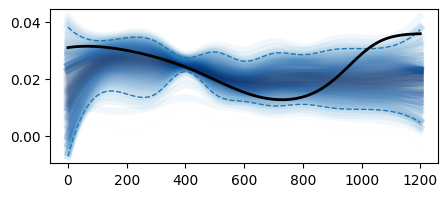

In [11]:
_ = plot(key, results, gt_profiles_apical)

In [12]:
key, results = post_process_apical(1)
processed_apical_posterior[key] = results

Processing  apical_SKv3_1_gSKv3_1
(129,)
(200, 129)


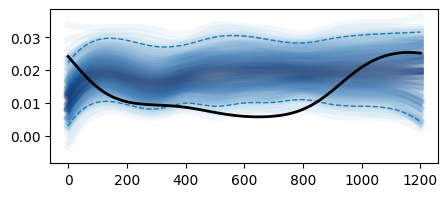

In [13]:
_ = plot(key, results, gt_profiles_apical)

In [14]:
key, results = post_process_apical(2)
processed_apical_posterior[key] = results

Processing  apical_M_gM
(129,)
(200, 129)


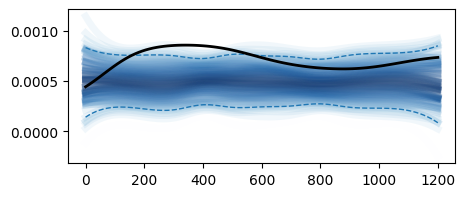

In [15]:
_ = plot(key, results, gt_profiles_apical)

In [16]:
processed_apical_posterior["bounds"] = bounds   
processed_apical_posterior["gt_profiles_apical"] = gt_profiles_apical

In [17]:
with open("processed_posterior_apical.pkl", "wb") as handle:
    pickle.dump(processed_apical_posterior, handle)

In [18]:
from voltage_imaging_utils import axonal_inds

assert len(axonal_inds) > 0

In [19]:
def post_process_axonal(i, q_low = 0.05, q_high = 0.95):
    axonal_gt = []
    axonal_found = []
    dists = []
    num_bins = 11
    
    keys = list(gt_profiles_axonal.keys())
    key = keys[i]
    print("Processing ", key)
    counter = 0
    for x in transform.forward(unflatten(samples[0])):#
        if key in x:
            break
        else:
            counter +=1
            
    samples_axonal = unflatten_samples[counter][key]


    dist_bins = np.linspace(50, 600, num_bins)
    dist_bin_assignments = []
    for b in axonal_inds:
        distance = cell.branch(b).loc(0.0).distance(cell.branch(0).loc(0.0))
        dists.append(distance)
        bin_ = np.digitize(distance, dist_bins)
        dist_bin_assignments.append(bin_)
        cond = np.interp(distance, evals, gt_profiles_axonal[key])
        axonal_gt.append(cond * bounds[key][1])
        cell.branch(b).set(key, cond * bounds[key][1])
        
    dist_bin_assignments = jnp.array(dist_bin_assignments)
    bins = []
    for i in range(num_bins):
        bins.append(samples_axonal[:,dist_bin_assignments == i].flatten())



    l = bounds[key][0]
    u = bounds[key][1]
    y_axis = jnp.linspace(l,u, 101)
    quantiles = []
    for b in bins:
        # Kde over bins
        b = jnp.array(b)
        q = jnp.quantile(b, jnp.linspace(0,1,101)) 
        quantiles.append(q[:,None])
        
    quantiles = jnp.hstack(quantiles)
    
    x_axis = jnp.linspace(0, 600, 100)

    quantiles_smoothed = gaussian_filter1d(quantiles, 0.1, axis=1)
    quantiles_smoothed_upscaled = jnp.stack([CubicSpline(dist_bins, quantiles_smoothed[i])(x_axis) for i in range(100)])

    alphas = jnp.linspace(0,1,101)

    idx_005 = jnp.argmin(jnp.abs(alphas - q_low))
    idx_095 = jnp.argmin(jnp.abs(alphas - q_high))
    
    results =  {"quantiles": quantiles_smoothed_upscaled, "alphas": alphas, "idx_005": idx_005, "idx_095": idx_095, "dist_bins": dist_bins, "bin_val":bins, "y_axis": y_axis, "x_axis": x_axis}
    return key, results

In [20]:
processed_axonal_posterior = {}

In [21]:
for i in range(7):
    key, results = post_process_axonal(i)
    processed_axonal_posterior[key] = results

Processing  axonal_NaTaT_gNaTaT
Processing  axonal_KPst_gKPst
Processing  axonal_KTst_gKTst
Processing  axonal_SKE2_gSKE2
Processing  axonal_SKv3_1_gSKv3_1
Processing  axonal_CaHVA_gCaHVA
Processing  axonal_CaLVA_gCaLVA


In [22]:
processed_axonal_posterior["bounds"] = bounds
processed_axonal_posterior["gt_profiles_axonal"] = gt_profiles_axonal

In [23]:
with open("processed_posterior_axonal.pkl", "wb") as handle:
    pickle.dump(processed_axonal_posterior, handle)

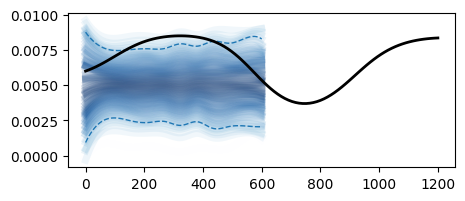

In [24]:
_ = plot(key, results, gt_profiles_axonal)

In [25]:
# Compose figs

In [26]:
#processed_posterior = jnp.load("processed_posterior_apical.npy", allow_pickle=True).item()
processed_posterior = processed_apical_posterior

In [27]:
processed_posterior.keys()

dict_keys(['apical_NaTs2T_gNaTs2T', 'apical_SKv3_1_gSKv3_1', 'apical_M_gM', 'bounds', 'gt_profiles_apical'])

0
1
2


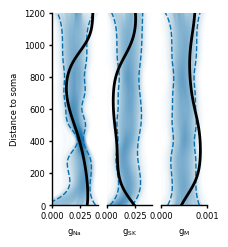

In [28]:
# Load mpl file
from nex.colors import cols
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
plt.style.use('../../.matplotlibrc')


color = cols["jaxley"]

fig, axs = plt.subplots(1,3, figsize=(2,2.5))
names = [r"$g_{Na}$", r"$g_{SK}$", r"$g_M$"]
keys = list(processed_posterior.keys())
bounds = processed_posterior["bounds"]
gt_profiles_apical = processed_posterior["gt_profiles_apical"]

# Hide y-axis ticks on the left

i=0
for key in keys:
    if key == "bounds" or key == "gt_profiles_apical":
        continue
    print(i)
    axs[i].set_xlabel(names[i])

    data = processed_posterior[key]
    xaxis = data["x_axis"]
    yaxis = data["y_axis"]
    q = data["quantiles"]
    idx_005 = data["idx_005"]
    idx_095 = data["idx_095"]

    if i == 0:
        axs[i].set_ylabel("Distance to soma")
    else:
        axs[i].spines['left'].set_visible(False)
        axs[i].yaxis.set_visible(False)
        
        
    for j in range(100):
        color_index = (1- jnp.abs(i - 50)/50)**0.1
        axs[i].plot(q[j],xaxis, color=color, alpha=0.02, lw=5)
    
    axs[i].plot(q[idx_005],xaxis,  color=color, lw=1, linestyle='--')
    axs[i].plot(q[idx_095],xaxis,  color=color, lw=1, linestyle='--')
    evals = np.linspace(0, 1200, 100)
    axs[i].plot(gt_profiles_apical[key] * bounds[key][1],evals, color='black', lw=2)
    axs[i].set_xlim(bounds[key])
    axs[i].set_ylim([0,1200])
    i+=1

# fig.suptitle("Apical spatial profiles")
# fig.savefig("apical_spatial_profiles.svg", bbox_inches='tight')
# fig.savefig("apical_spatial_profiles.png", bbox_inches='tight')

In [29]:
#processed_posterior = jnp.load("processed_posterior_axonal.npy", allow_pickle=True).item()
processed_posterior = processed_axonal_posterior

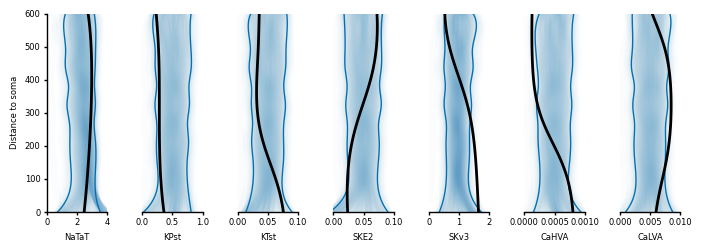

In [30]:
# Load mpl file
from nex.colors import cols
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
plt.style.use('../../.matplotlibrc')


color = cols["jaxley"]
keys = list(processed_posterior.keys())
fig, axs = plt.subplots(1,len(keys)-2, figsize=(7,2.5))
names = [k.split("_")[1] for k in keys[:-2]]

bounds = processed_posterior["bounds"]
gt_profiles_apical = processed_posterior["gt_profiles_axonal"]

# Hide y-axis ticks on the left

for i in range(len(keys)-2):
    key = keys[i]
    axs[i].set_xlabel(names[i])
            
    data = processed_posterior[key]
    xaxis = data["x_axis"]
    yaxis = data["y_axis"]
    q = data["quantiles"]
    idx_005 = data["idx_005"]
    idx_095 = data["idx_095"]

    if i == 0:
        axs[i].set_ylabel("Distance to soma")
    else:
        axs[i].spines['left'].set_visible(False)
        axs[i].yaxis.set_visible(False)

        
    for j in range(100):
        color_index = (1- jnp.abs(i - 50)/50)**0.1
        axs[i].plot(q[j],xaxis, color=color, alpha=0.02, lw=5)
    
    axs[i].plot(q[idx_005],xaxis,  color=color, lw=1)
    axs[i].plot(q[idx_095],xaxis,  color=color, lw=1)
    evals = np.linspace(0, 1200, 100)
    axs[i].plot(gt_profiles_apical[key] * bounds[key][1],evals, color='black', lw=2)
    axs[i].set_xlim(bounds[key])
    axs[i].set_ylim([0,600])
fig.tight_layout()
# fig.suptitle("Axonal spatial profiles",y=1.1)
# fig.savefig("axonal_spatial_profiles.svg", bbox_inches='tight')
# fig.savefig("axonal_spatial_profiles.png", bbox_inches='tight')

